All the imports

In [52]:
import cv2
import numpy as np
from dataclasses import dataclass
from typing import Dict, Any, Tuple
import matplotlib.pyplot as plt
%matplotlib inline

@dataclass
class LeafTraits:
    morphological: Dict[str, float]
    color: Dict[str, float]
    texture: Dict[str, float]
    chlorophyll: Dict[str, float]
    health: Dict[str, float]

Physical Traits


In [ ]:


class ComprehensiveLeafAnalyzer:
    def __init__(self):
        self.min_contour_area = 100
        self.pixels_per_cm = None
        # Normalization constants
        self.max_contrast = 100.0
        self.max_entropy = 8.0
        self.hue_norm = 180.0  # Maximum hue value
        self.texture_norm = 255.0  # Maximum pixel value
        
    def analyze_leaf(self, image: np.ndarray) -> LeafTraits:
        """
        Comprehensive analysis pipeline for traditional CV measurements
        """
        image_copy = image.copy()
        
        mask = self._create_mask(image_copy)
        
    
        morphological = self._get_morphological_traits(mask)
        color = self._get_color_traits(image_copy, mask)
        texture = self._get_texture_traits(image_copy, mask)
        chlorophyll = self._estimate_chlorophyll(image_copy, mask)
        health = self._assess_health_indicators(image_copy, mask)
        
        return LeafTraits(
            morphological=morphological,
            color=color,
            texture=texture,
            chlorophyll=chlorophyll,
            health=health
        )
    
    def _create_mask(self, image: np.ndarray) -> np.ndarray:
        """
        Create binary mask for leaf with enhanced preprocessing
        """
        # Convert to HSV
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # Green range in HSV
        lower_green = np.array([25, 40, 40])
        upper_green = np.array([85, 255, 255])
        
        # Create mask
        mask = cv2.inRange(hsv, lower_green, upper_green)
        
        # Enhanced cleanup
        kernel = np.ones((5,5), np.uint8)
        # The correct constants are MORPH_CLOSE and MORPH_OPEN
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        
        return mask
    
    def _get_morphological_traits(self, mask: np.ndarray) -> Dict[str, float]:
        """
        Calculate comprehensive morphological traits
        """
        traits = {}
        
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            cnt = max(contours, key=cv2.contourArea)
            
            
            traits['area'] = cv2.contourArea(cnt)
            traits['perimeter'] = cv2.arcLength(cnt, True)
            traits['circularity'] = 4 * np.pi * traits['area'] / (traits['perimeter'] ** 2)
            
            
            x, y, w, h = cv2.boundingRect(cnt)
            traits['length'] = max(w, h)
            traits['width'] = min(w, h)
            traits['aspect_ratio'] = float(w) / h
            

            (x, y), radius = cv2.minEnclosingCircle(cnt)
            traits['radius'] = radius
            traits['compactness'] = traits['area'] / (np.pi * radius ** 2)
            
            
            hull = cv2.convexHull(cnt)
            hull_area = cv2.contourArea(hull)
            traits['convexity'] = traits['area'] / hull_area if hull_area > 0 else 0
            
           
            moments = cv2.moments(cnt)
            if moments['m00'] != 0:
                # Centroid
                cx = moments['m10'] / moments['m00']
                cy = moments['m01'] / moments['m00']
                
               
                left = mask[:, :int(cx)]
                right = mask[:, int(cx):]
                right_flipped = cv2.flip(right, 1)
                min_width = min(left.shape[1], right_flipped.shape[1])
                traits['symmetry'] = np.sum(left[:, :min_width] == 
                                          right_flipped[:, :min_width]) / (min_width * mask.shape[0])
                
                if moments['mu20'] + moments['mu02'] != 0:
                    ecc = ((moments['mu20'] - moments['mu02'])**2 + 
                          4*moments['mu11']**2) / (moments['mu20'] + moments['mu02'])**2
                    traits['eccentricity'] = ecc
            
            
            traits['equivalent_diameter'] = np.sqrt(4 * traits['area'] / np.pi)
            
        return traits
    
    def _get_color_traits(self, image: np.ndarray, mask: np.ndarray) -> Dict[str, float]:
        """
        Calculate comprehensive color traits
        """
        traits = {}
        
                
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        
        # Split channels
        b, g, r = cv2.split(image)
        h, s, v = cv2.split(hsv)
        l, a, b_channel = cv2.split(lab)
        
        mask_bool = mask > 0
        if np.any(mask_bool):
            # Normalize RGB
            r_norm = r[mask_bool].astype(float) / 255
            g_norm = g[mask_bool].astype(float) / 255
            b_norm = b[mask_bool].astype(float) / 255
            
            # Basic color metrics
            traits['green_intensity'] = np.mean(g_norm)
            traits['red_intensity'] = np.mean(r_norm)
            traits['blue_intensity'] = np.mean(b_norm)
            
            # Color indices
            traits['dgci'] = np.mean(((256 - r_norm) + g_norm - b_norm) / (3 * 256))
            traits['gcc'] = np.mean(g_norm / (r_norm + g_norm + b_norm + 1e-6))
            traits['excess_green'] = np.mean(2 * g_norm - r_norm - b_norm)
            
            # HSV metrics
            traits['mean_hue'] = np.mean(h[mask_bool])
            traits['mean_saturation'] = np.mean(s[mask_bool])
            traits['mean_value'] = np.mean(v[mask_bool])
            
            # LAB metrics
            traits['mean_lightness'] = np.mean(l[mask_bool])
            traits['mean_a'] = np.mean(a[mask_bool])
            traits['mean_b'] = np.mean(b_channel[mask_bool])
            
            # Color uniformity
            traits['color_uniformity'] = 1 - np.std(g_norm)
            traits['hue_uniformity'] = 1 - np.std(h[mask_bool])
            
            # Yellowing detection
            traits['yellowing'] = np.mean((r_norm + g_norm) / 2 - b_norm)
            
        return traits
    
    def _get_texture_traits(self, image: np.ndarray, mask: np.ndarray) -> Dict[str, float]:
        """
        Calculate comprehensive texture traits with normalized values
        """
        traits = {}
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        masked_gray = cv2.bitwise_and(gray, gray, mask=mask)
        
        if np.any(mask > 0):
            # Normalized smoothness
            traits['smoothness'] = np.clip(1 - np.std(masked_gray[mask > 0]) / 255, 0, 1)
            
            # Normalized local contrast
            kernel = np.ones((3,3), np.float32) / 9
            local_mean = cv2.filter2D(masked_gray, -1, kernel)
            traits['local_contrast'] = np.clip(
                np.mean(np.abs(masked_gray - local_mean)[mask > 0]) / 255, 
                0, 1
            )
            
            # Normalized entropy
            hist = cv2.calcHist([masked_gray], [0], mask, [256], [0,256])
            hist = hist / hist.sum()
            hist = hist[hist > 0]
            traits['entropy'] = np.clip(-np.sum(hist * np.log2(hist)) / 8, 0, 1)
            
            # Normalized GLCM features
            masked_pixels = masked_gray[mask > 0]
            if len(masked_pixels) > 0:
                glcm = self._calculate_glcm(masked_pixels.reshape(-1, 1))
                traits['glcm_contrast'] = np.clip(self._glcm_contrast(glcm) / 100, 0, 1)
                traits['glcm_homogeneity'] = self._glcm_homogeneity(glcm)  # Already normalized
        
        return traits
    
    def _estimate_chlorophyll(self, image: np.ndarray, mask: np.ndarray) -> Dict[str, float]:
        """
        Estimate chlorophyll content using multiple indices
        """
        traits = {}
        
        b, g, r = cv2.split(image)
        mask_bool = mask > 0
        
        if np.any(mask_bool):
            # Normalize values
            r_norm = r[mask_bool].astype(float) / 255
            g_norm = g[mask_bool].astype(float) / 255
            b_norm = b[mask_bool].astype(float) / 255
            
            # Various vegetation indices
            # DGCI (Dark Green Color Index)
            traits['dgci'] = np.mean(((256 - r_norm) + g_norm - b_norm) / (3 * 256))
            
            # VARI (Visible Atmospherically Resistant Index)
            denominator = g_norm + r_norm - b_norm
            vari = (g_norm - r_norm) / (denominator + 1e-6)
            traits['vari'] = np.mean(vari)
            
            # GLI (Green Leaf Index)
            gli_num = 2 * g_norm - r_norm - b_norm
            gli_den = 2 * g_norm + r_norm + b_norm
            traits['gli'] = np.mean(gli_num / (gli_den + 1e-6))
            
            # MGRVI (Modified Green Red Vegetation Index)
            traits['mgrvi'] = np.mean((g_norm**2 - r_norm**2) / (g_norm**2 + r_norm**2 + 1e-6))
            
            # Estimate relative chlorophyll content
            traits['relative_chlorophyll'] = (traits['dgci'] * 0.4 +
                                            traits['vari'] * 0.3 +
                                            traits['gli'] * 0.2 +
                                            traits['mgrvi'] * 0.1)
            
        return traits
    
    def _assess_health_indicators(self, image: np.ndarray, mask: np.ndarray) -> Dict[str, float]:
        """
        Assess various health indicators with normalized values
        """
        traits = {}
        
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mask_bool = mask > 0
        
        if np.any(mask_bool):
            # Color-based health indicators
            h, s, v = cv2.split(hsv)
            
            # Yellowing detection (normalized)
            yellow_range = cv2.inRange(hsv, np.array([20, 100, 100]), np.array([30, 255, 255]))
            traits['yellowing_ratio'] = np.clip(np.sum(yellow_range & mask) / np.sum(mask), 0, 1)
            
            # Normalized vigor
            traits['vigor'] = np.clip(np.mean(s[mask_bool]) / 255, 0, 1)
            
            # Normalized color health
            traits['color_health'] = np.clip(1 - np.std(h[mask_bool])/180, 0, 1)
            
            # Calculate normalized green ratio
            b, g, r = cv2.split(image)
            g_ratio = g.astype(float) / (r.astype(float) + b.astype(float) + 1e-6)
            traits['green_ratio'] = np.clip(np.mean(g_ratio[mask_bool]), 0, 1)
            
        return traits
    
    def _calculate_glcm(self, image: np.ndarray, distances: list = [1], 
                       angles: list = [0]) -> np.ndarray:
        """
        Calculate Gray-Level Co-occurrence Matrix
        """
        glcm = np.zeros((256, 256))
        for i in range(image.shape[0]-1):
            for j in range(image.shape[1]-1):
                glcm[image[i,j], image[i+1,j+1]] += 1
        return glcm / (glcm.sum() + 1e-6)
    
    def _glcm_contrast(self, glcm: np.ndarray) -> float:
        """
        Calculate GLCM contrast
        """
        contrast = 0
        for i in range(glcm.shape[0]):
            for j in range(glcm.shape[1]):
                contrast += glcm[i,j] * (i-j)**2
        return contrast
    
    def _glcm_homogeneity(self, glcm: np.ndarray) -> float:
        """
        Calculate GLCM homogeneity
        """
        homogeneity = 0
        for i in range(glcm.shape[0]):
            for j in range(glcm.shape[1]):
                homogeneity += glcm[i,j] / (1 + abs(i-j))
        return homogeneity

"Individual Analysis"

In [ ]:
def interpret_morphological(traits):
    """Interpret morphological traits"""
    circularity = traits['circularity']
    symmetry = traits['symmetry']
    aspect_ratio = traits['aspect_ratio']
    
    interpretation = "Leaf Shape Analysis:\n"
    if circularity > 0.85:
        interpretation += "- Very circular leaf shape\n"
    elif circularity > 0.7:
        interpretation += "- Moderately circular leaf shape\n"
    else:
        interpretation += "- Irregular leaf shape\n"
        
    if symmetry > 0.95:
        interpretation += "- Highly symmetric\n"
    elif symmetry > 0.8:
        interpretation += "- Moderately symmetric\n"
    else:
        interpretation += "- Asymmetric leaf\n"
        
    if aspect_ratio > 0.9:
        interpretation += "- Nearly round shape\n"
    elif aspect_ratio > 0.7:
        interpretation += "- Oval shape\n"
    else:
        interpretation += "- Elongated shape\n"
    
    return interpretation

def plot_morphological_metrics(traits):
    """
    Plot morphological metrics with proper value ranges
    """
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(111, projection='polar')
    metrics = {
        'Circularity': traits['circularity'],
        'Aspect Ratio': traits['aspect_ratio'],
        'Symmetry': traits['symmetry'],
        'Compactness': traits['compactness']
    }
    
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    values = list(metrics.values())
    values += values[:1]
    angles = np.concatenate((angles, [angles[0]]))
    
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(list(metrics.keys()))
    
    max_val = max(values)
    min_val = min(values)
    padding = (max_val - min_val) * 0.1  # 10% padding
    ax.set_ylim(max(0, min_val - padding), min(1.2, max_val + padding))
    
    plt.title('Morphological Metrics')
    for i, value in enumerate(values[:-1]):
        ax.text(angles[i], values[i], f'{values[i]:.3f}', 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def interpret_chlorophyll(traits):
    """Interpret chlorophyll indices"""
    # Now accessing the dictionary directly
    rel_chlorophyll = traits['relative_chlorophyll']
    
    interpretation = "Chlorophyll Content Analysis:\n"
    if rel_chlorophyll > 0.6:
        interpretation += "- High chlorophyll content indicating very healthy leaf\n"
    elif rel_chlorophyll > 0.3:
        interpretation += "- Moderate chlorophyll content indicating normal health\n"
    else:
        interpretation += "- Low chlorophyll content suggesting possible stress\n"
        
    return interpretation

def plot_chlorophyll_indices(traits):
    """
    Plot chlorophyll indices with enhanced visibility of differences
    """
    plt.figure(figsize=(12, 8))
    
    metrics = {
        'DGCI': traits['dgci'],
        'GLI': traits['gli'],
        'VARI': traits['vari'],
        'Rel. Chlorophyll': traits['relative_chlorophyll']
    }
    
    x = range(len(metrics))
    values = list(metrics.values())
    plt.plot(x, values, 'go-', linewidth=2, markersize=10)
    plt.xticks(x, metrics.keys(), rotation=45)
    
    # Adjust y-limits to better show differences
    max_val = max(values)
    min_val = min(values)
    padding = (max_val - min_val) * 0.1
    plt.ylim(min_val - padding, max_val + padding)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title('Chlorophyll Indices')
    
    # Add value labels
    for i, value in enumerate(values):
        plt.text(i, value, f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


def plot_health_indicators(traits):
    """
    Plot health indicators with enhanced visibility
    """
    plt.figure(figsize=(12, 8))
    
    metrics = {
        'Vigor': traits['vigor'],
        'Color Health': traits['color_health'],
        'Green Ratio': traits['green_ratio']
    }
    
    y_pos = range(len(metrics))
    values = list(metrics.values())
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(metrics)))
    
    bars = plt.barh(y_pos, values, color=colors)
    plt.yticks(y_pos, list(metrics.keys()))
    
    for i, v in enumerate(values):
        plt.text(v, i, f' {v:.3f}', va='center')
    
    plt.xlim(0, 1.0)
    plt.title('Health Indicators')
    plt.tight_layout()
    plt.show()

def interpret_health(traits):
    """Interpret health indicators"""
    vigor = traits['vigor']
    color_health = traits['color_health']
    green_ratio = traits['green_ratio']
    
    interpretation = "Health Status Analysis:\n"
    if vigor > 0.7:
        interpretation += "- High vigor indicating robust health\n"
    elif vigor > 0.4:
        interpretation += "- Moderate vigor suggesting normal health\n"
    else:
        interpretation += "- Low vigor indicating possible stress\n"
        
    if color_health > 0.9:
        interpretation += "- Excellent color uniformity\n"
    elif color_health > 0.7:
        interpretation += "- Good color uniformity\n"
    else:
        interpretation += "- Uneven coloration suggesting issues\n"
        
    return interpretation

def interpret_texture(traits):
    """Interpret texture features"""
    smoothness = traits['smoothness']
    entropy = traits['entropy']
    
    interpretation = "Texture Analysis:\n"
    if smoothness > 0.9:
        interpretation += "- Very smooth leaf surface\n"
    elif smoothness > 0.7:
        interpretation += "- Moderately smooth surface\n"
    else:
        interpretation += "- Rough leaf surface\n"
        
    if entropy < 0.2:
        interpretation += "- Very uniform texture\n"
    elif entropy < 0.5:
        interpretation += "- Moderately textured\n"
    else:
        interpretation += "- Complex texture patterns\n"
        
    return interpretation

def plot_texture_features(traits):
    """
    Plot texture features with enhanced visibility
    """
    plt.figure(figsize=(12, 8))
    
    metrics = {
        'Smoothness': traits['smoothness'],
        'Contrast': traits['local_contrast'] / 100,
        'Entropy': traits['entropy'] / 8
    }
    
    x = range(len(metrics))
    values = list(metrics.values())
    sizes = np.array(values) * 1000
    
    plt.scatter(x, values, s=sizes, alpha=0.6, c=values, cmap='viridis')
    plt.xticks(x, metrics.keys(), rotation=45)
    
    for i, value in enumerate(values):
        plt.text(i, value, f'{value:.3f}', ha='center', va='bottom')
    
    max_val = max(values)
    min_val = min(values)
    padding = (max_val - min_val) * 0.1
    plt.ylim(max(0, min_val - padding), min(1.0, max_val + padding))
    
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.title('Texture Features')
    plt.tight_layout()
    plt.show()

Visualize and Analyze Function

In [ ]:
def visualize_analysis_enhanced(image, mask, traits: LeafTraits):
    """
    Enhanced visualization with different plot types for each trait category
    """
    fig = plt.figure(figsize=(20, 15))

    plt.subplot(231)
    img_with_measures = image.copy()
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Fixed syntax
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        cv2.drawContours(img_with_measures, [cnt], -1, (0, 255, 0), 2)
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.putText(img_with_measures, f"L: {traits.morphological['length']:.0f}px",
                    (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
        cv2.putText(img_with_measures, f"W: {traits.morphological['width']:.0f}px",
                    (x, y-30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    plt.imshow(cv2.cvtColor(img_with_measures, cv2.COLOR_BGR2RGB))
    plt.title('Original Image with Measurements')
    plt.axis('off')
    
    # Mask visualization
    plt.subplot(232)
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    if contours:
        cv2.drawContours(mask_rgb, [cnt], -1, (0, 255, 0), 2)
    plt.imshow(mask_rgb)
    plt.title('Leaf Mask with Contour')
    plt.axis('off')
    
    # Morphological Metrics - Radar Plot
    ax = plt.subplot(233, projection='polar')
    morph_metrics = {
        'Circularity': traits.morphological['circularity'],
        'Aspect Ratio': traits.morphological['aspect_ratio'],
        'Symmetry': traits.morphological['symmetry'],
        'Compactness': traits.morphological['compactness']
    }
    angles = np.linspace(0, 2*np.pi, len(morph_metrics), endpoint=False)
    values = list(morph_metrics.values())
    values += values[:1]
    angles = np.concatenate((angles, [angles[0]]))
    
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(list(morph_metrics.keys()))
    ax.set_ylim(0, 1.2)
    plt.title('Morphological Metrics')
    
    # Chlorophyll Indices - Line Plot with Markers
    ax = plt.subplot(234)
    chloro_metrics = {
        'DGCI': traits.chlorophyll['dgci'],
        'GLI': traits.chlorophyll['gli'],
        'VARI': traits.chlorophyll['vari'],
        'Rel. Chlorophyll': traits.chlorophyll['relative_chlorophyll']
    }
    x = range(len(chloro_metrics))
    plt.plot(x, list(chloro_metrics.values()), 'go-', linewidth=2, markersize=10)
    plt.xticks(x, chloro_metrics.keys(), rotation=45)
    plt.ylim(-0.5, 1.0)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title('Chlorophyll Indices')
    
    # Health Indicators - Horizontal Bars with Gradient
    ax = plt.subplot(235)
    health_metrics = {
        'Vigor': traits.health['vigor'],
        'Color Health': traits.health['color_health'],
        'Green Ratio': traits.health['green_ratio']
    }
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(health_metrics)))
    bars = ax.barh(list(health_metrics.keys()), list(health_metrics.values()), 
                   color=colors)
    ax.set_xlim(0, 1.0)
    plt.title('Health Indicators')
    
    # Texture Features - Bubble Plot
    ax = plt.subplot(236)
    texture_metrics = {
        'Smoothness': traits.texture['smoothness'],
        'Contrast': traits.texture['local_contrast'] / 100,
        'Entropy': traits.texture['entropy'] / 8
    }
    x = range(len(texture_metrics))
    y = list(texture_metrics.values())
    sizes = np.array(y) * 1000  # Scale for bubble size
    plt.scatter(x, y, s=sizes, alpha=0.6, c=y, cmap='viridis')
    plt.xticks(x, texture_metrics.keys(), rotation=45)
    plt.ylim(0, 1.0)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.title('Texture Features')
    
    plt.tight_layout()
    plt.show()

def analyze_and_visualize(image_path):
    """
    Analyze leaf and show results with visualization
    """
    # Initialize analyzer
    analyzer = ComprehensiveLeafAnalyzer()
    
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read image")
        return
    
    # Analyze leaf
    traits = analyzer.analyze_leaf(image)
    
    # Get mask for visualization
    mask = analyzer._create_mask(image)
    
    # Print detailed results
    print("\nLeaf Analysis Results:")
    
    print("\nMorphological Traits:")
    for name, value in traits.morphological.items():
        print(f"{name}: {value:.3f}")
    
    print("\nColor Traits:")
    for name, value in traits.color.items():
        print(f"{name}: {value:.3f}")
    
    print("\nTexture Traits:")
    for name, value in traits.texture.items():
        print(f"{name}: {value:.3f}")
    
    print("\nChlorophyll Estimation:")
    for name, value in traits.chlorophyll.items():
        print(f"{name}: {value:.3f}")
    
    print("\nHealth Indicators:")
    for name, value in traits.health.items():
        print(f"{name}: {value:.3f}")
    
    # Visualize results
    visualize_analysis_enhanced(image, mask, traits)
    
    return traits

def analyze_with_individual_plots(image_path):
    """
    Analyze leaf and show individual plots with interpretations
    """
    analyzer = ComprehensiveLeafAnalyzer()
    image = cv2.imread(image_path)
    
    if image is None:
        print("Error: Could not read image")
        return
    
    traits = analyzer.analyze_leaf(image)
    
    # Show original image and mask
    mask = analyzer._create_mask(image)
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(mask, cmap='gray')
    plt.title('Leaf Mask')
    plt.axis('off')
    plt.show()
    s
    plot_morphological_metrics(traits.morphological)
    plot_chlorophyll_indices(traits.chlorophyll)
    plot_health_indicators(traits.health)
    plot_texture_features(traits.texture)
    
    return traits

Main Function for Running



Leaf Analysis Results:

Morphological Traits:
area: 3883.500
perimeter: 239.782
circularity: 0.849
length: 72.000
width: 66.000
aspect_ratio: 0.917
radius: 40.750
compactness: 0.744
convexity: 0.979
symmetry: 0.999
eccentricity: 0.037
equivalent_diameter: 70.318

Color Traits:
green_intensity: 0.563
red_intensity: 0.359
blue_intensity: 0.335
dgci: 0.333
gcc: 0.448
excess_green: 0.433
mean_hue: 57.140
mean_saturation: 103.520
mean_value: 143.630
mean_lightness: 139.426
mean_a: 98.648
mean_b: 153.467
color_uniformity: 0.894
hue_uniformity: -2.263
yellowing: 0.126

Texture Traits:
smoothness: 0.910
local_contrast: 0.358
entropy: 0.768
glcm_contrast: 0.000
glcm_homogeneity: 0.000

Chlorophyll Estimation:
dgci: 0.333
vari: 0.349
gli: 0.238
mgrvi: 0.423
relative_chlorophyll: 0.328

Health Indicators:
yellowing_ratio: 0.000
vigor: 0.406
color_health: 0.982
green_ratio: 0.814


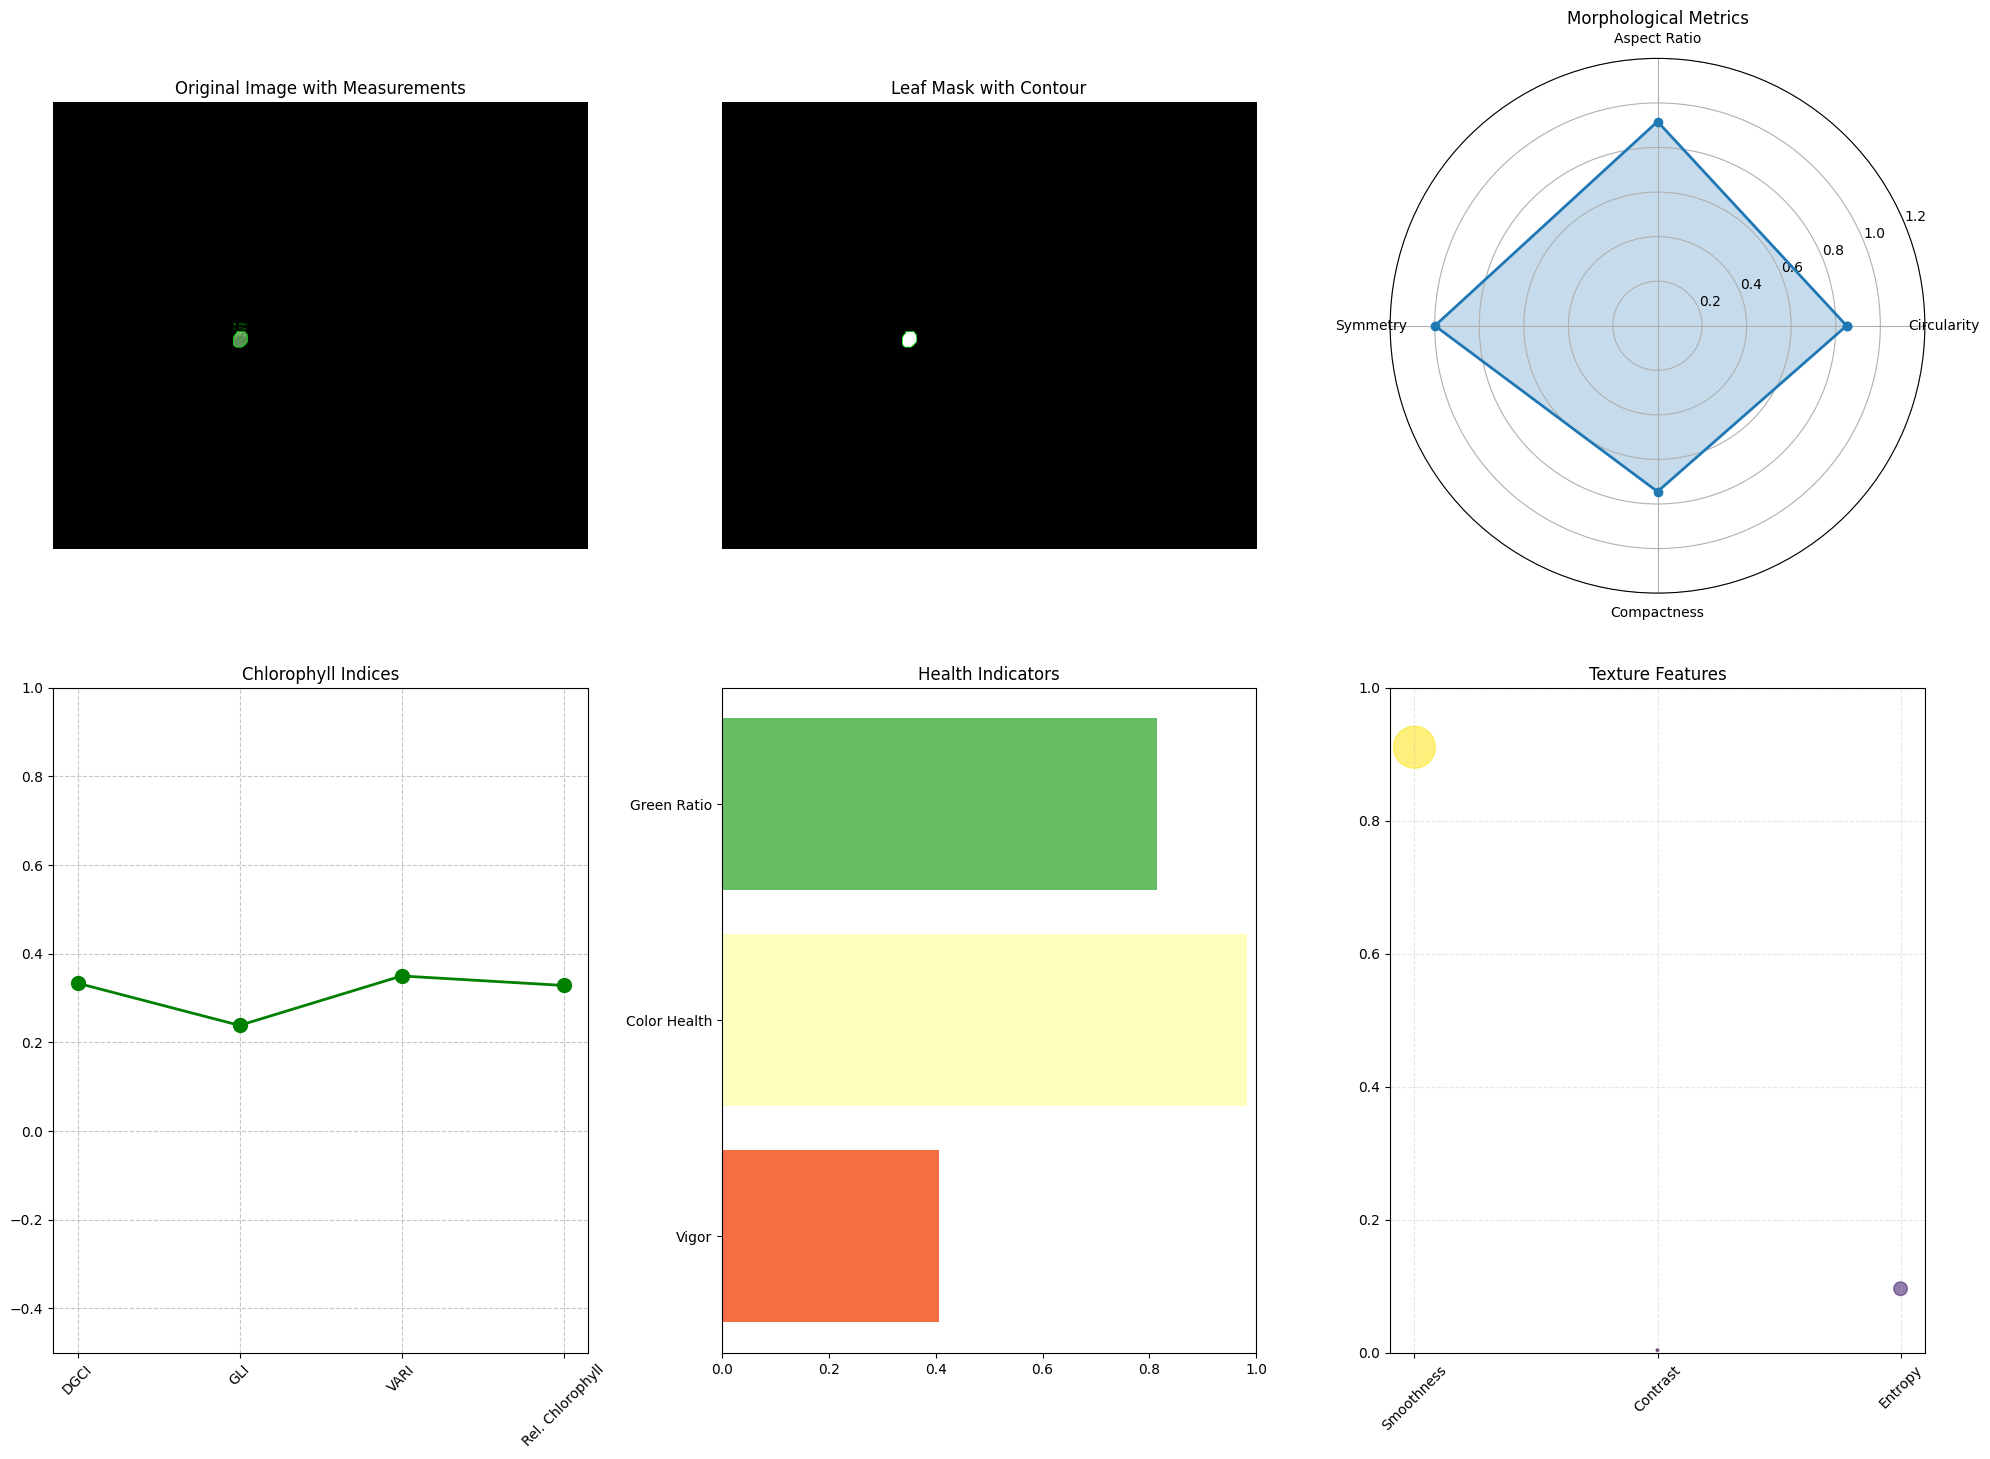

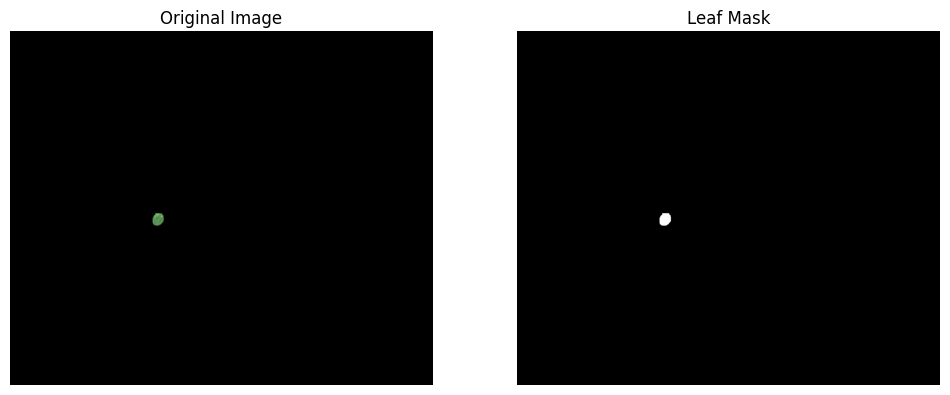

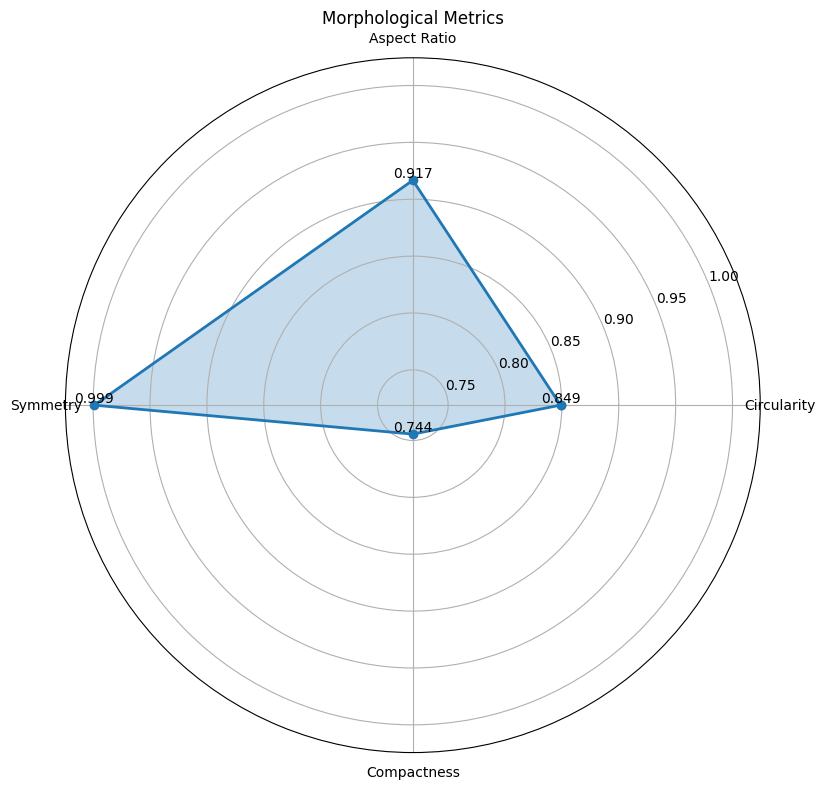

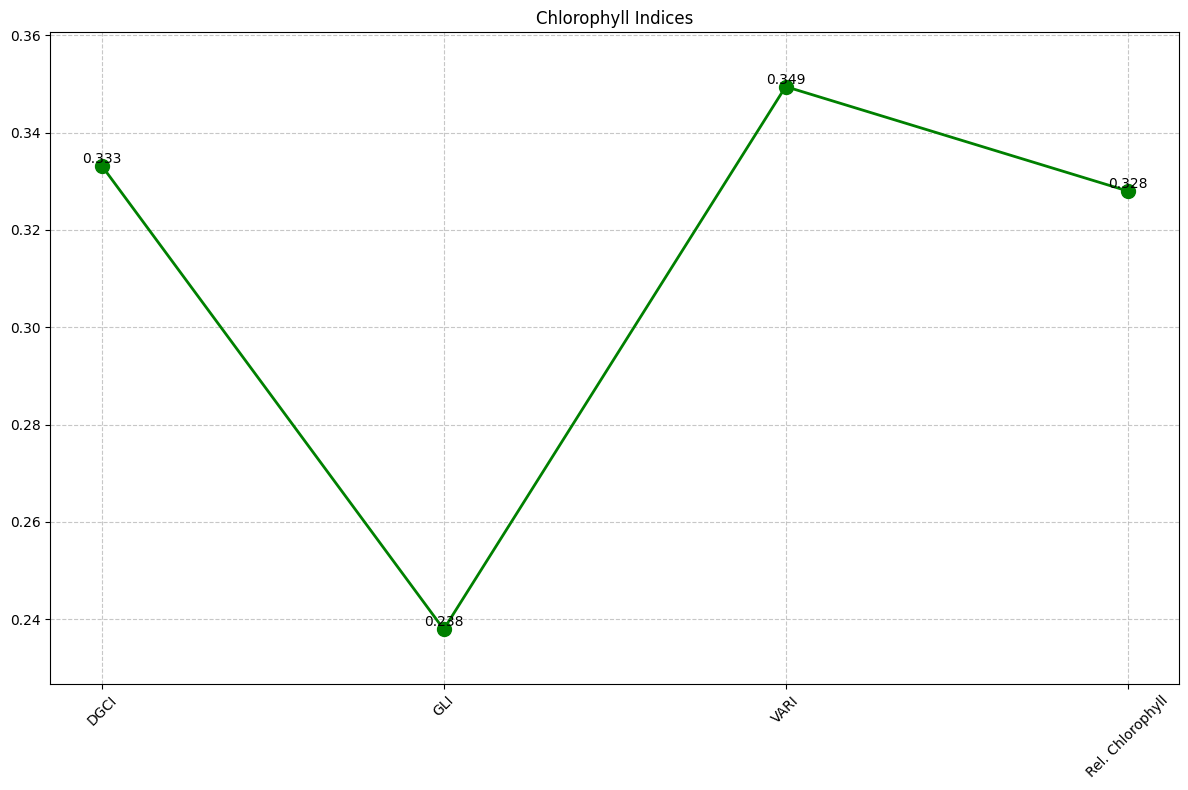

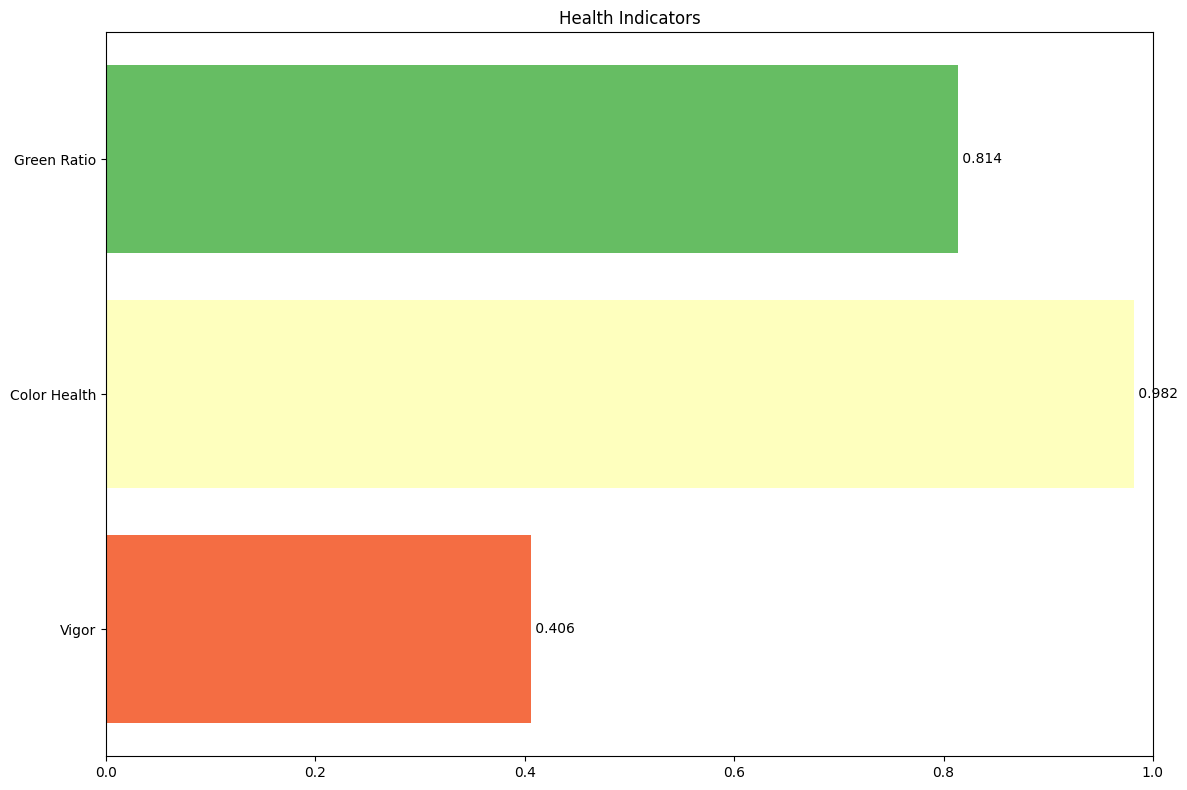

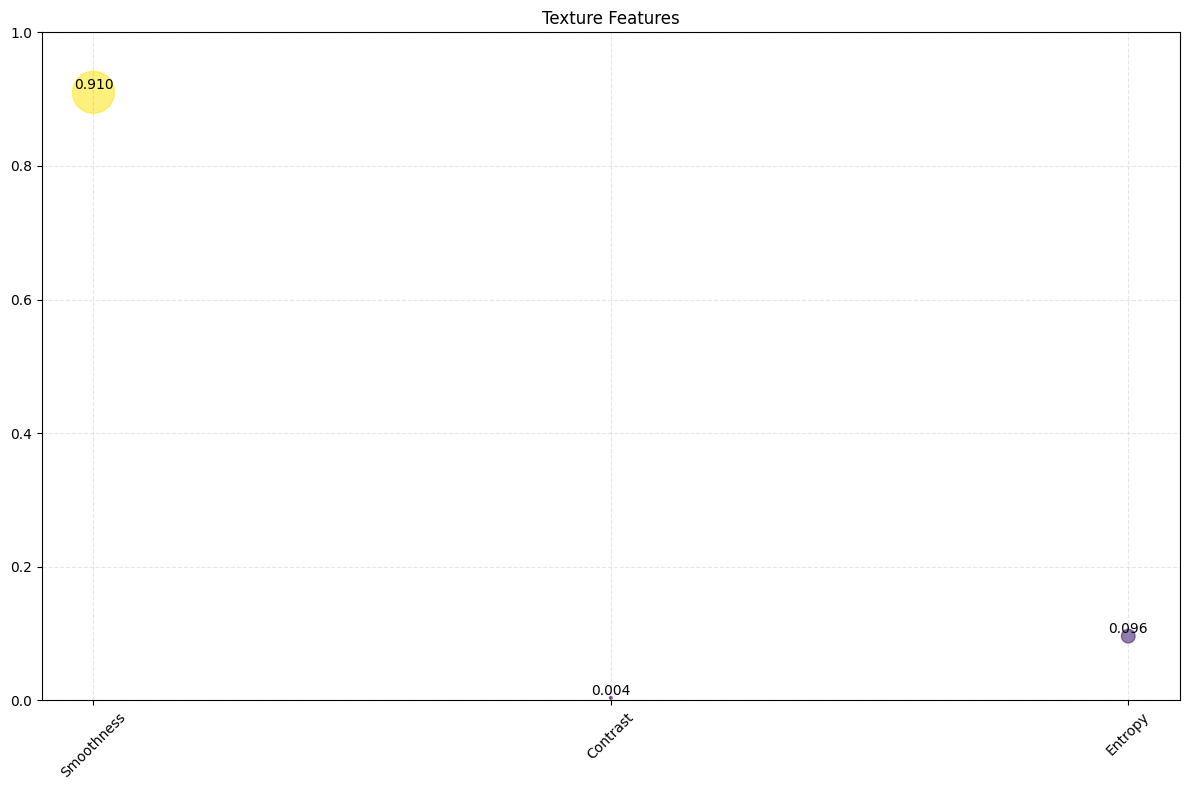

In [59]:
image_path = '/home/faisalnazir/Desktop/Sproj_Work/Combined/segmented/036.jpg/masked_object_2.png'  
traits = analyze_and_visualize(image_path)
traits = analyze_with_individual_plots(image_path)
plt.close('all')
plt.pause(1)